In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

color = ['red','yellow']

In [2]:
train = pd.read_csv('train_loan.csv')
test = pd.read_csv('test_loan.csv')
submission = pd.read_csv('sample_submission.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
cat_cols = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Amount_Term']
target = 'Loan_Status'

In [4]:
print("Percentage of Approved loan Status: " , train['Loan_Status'][(train['Loan_Status'] == 'Y')].value_counts()[0]/len(train['Loan_Status']) * 100)
print("Percentage of Rejected loan Status: " , train['Loan_Status'][(train['Loan_Status'] == 'N')].value_counts()[0]/len(train['Loan_Status']) * 100)

Percentage of Approved loan Status:  68.72964169381108
Percentage of Rejected loan Status:  31.27035830618892


In [5]:
print(train['Loan_Status'][(train['Loan_Status'] == 'Y')].value_counts())
print(train['Loan_Status'][(train['Loan_Status'] == 'N')].value_counts())

Y    422
Name: Loan_Status, dtype: int64
N    192
Name: Loan_Status, dtype: int64


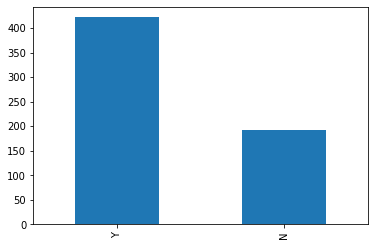

In [6]:
train['Loan_Status'].value_counts().plot.bar()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
train.Gender.value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [10]:
train.Gender.fillna(train.Gender.mode()[0],inplace = True)
test.Gender.fillna(test.Gender.mode()[0],inplace = True)

In [11]:
train.Married.value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [12]:
train.Gender.fillna(train.Gender.mode()[0],inplace = True)
test.Gender.fillna(test.Gender.mode()[0],inplace = True)

In [13]:
train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [14]:
train.Dependents.fillna(train.Dependents.mode()[0],inplace = True)
test.Dependents.fillna(test.Dependents.mode()[0],inplace = True)

In [15]:
train.Self_Employed.fillna(train.Self_Employed.mode()[0],inplace = True)
test.Self_Employed.fillna(test.Self_Employed.mode()[0],inplace = True)

In [16]:
train.Credit_History.fillna(train.Credit_History.mode()[0],inplace=True)
test.Credit_History.fillna(train.Credit_History.mode()[0],inplace=True)

In [17]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               3
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [18]:
train.Married.fillna(train.Married.mode()[0],inplace=True)
test.Married.fillna(train.Married.mode()[0],inplace=True)

In [19]:
train.LoanAmount.mean()

146.41216216216216

In [20]:
train.LoanAmount.fillna(train.LoanAmount.median(), inplace = True)
test.LoanAmount.fillna(test.LoanAmount.median(), inplace = True)

In [21]:
train.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [22]:
train.Loan_Amount_Term.fillna(train.Loan_Amount_Term.mode()[0], inplace = True)
test.Loan_Amount_Term.fillna(test.Loan_Amount_Term.mode()[0], inplace = True)

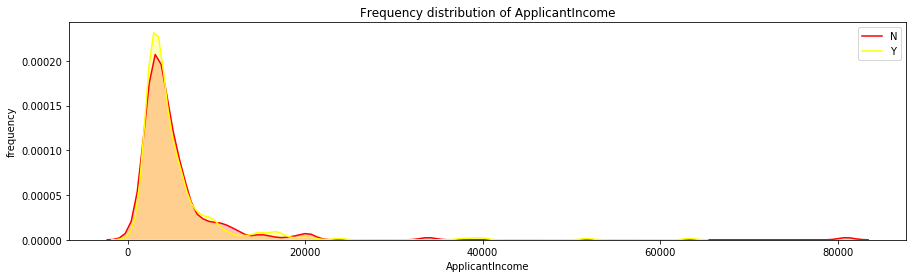

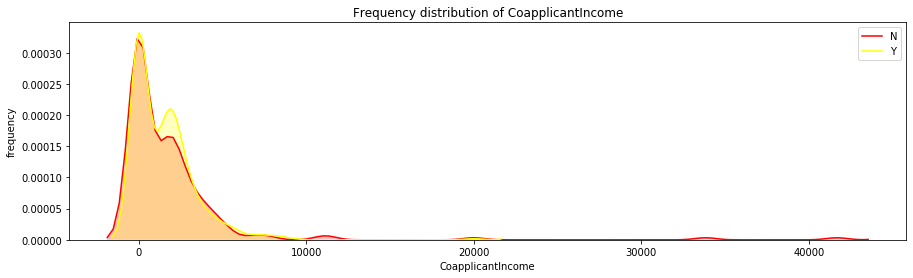

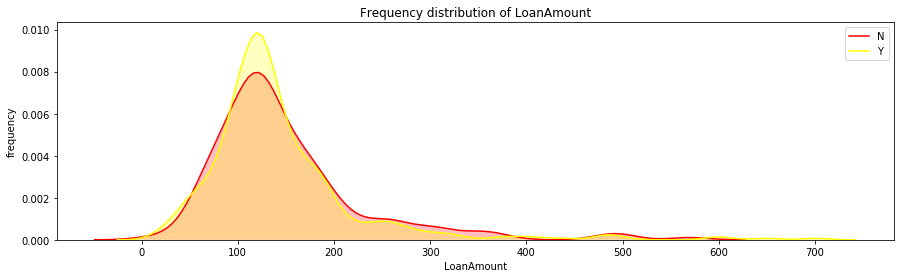

In [23]:
# numeric vs numeric
colors = ['red','yellow']
for col in num_cols:
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(111)
    j = 0
    for key, df in train.groupby([target]):
        sns.kdeplot(train[col][(train[target] == key)],color = colors[j], shade=True, label = key)
        ax.set_xlabel(col)
        ax.set_ylabel("frequency")
        ax.set_title("Frequency distribution of {}".format(col))
        ax.legend(loc = "best")
        j = j+1

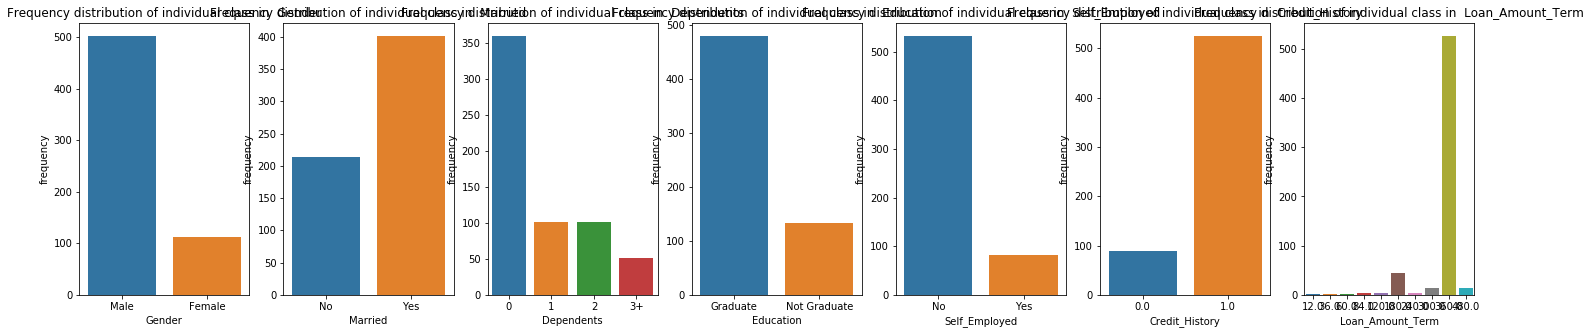

In [24]:
#categorical as univariate
fig = plt.figure(figsize=(25,5))
j = 1
for col in cat_cols:
    
    ax = fig.add_subplot(1,len(cat_cols),j)
    sns.countplot(x = col, data = train, ax = ax)
    ax.set_xlabel(col)
    ax.set_ylabel("frequency")
    ax.set_title("Frequency distribution of individual class in  {}".format(col))
    j = j+1

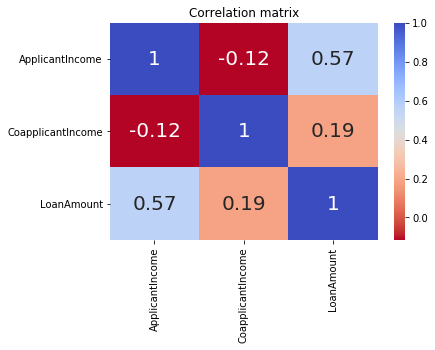

In [25]:
sns.heatmap(train[num_cols].corr(),cmap='coolwarm_r', annot_kws={'size':20},annot = True)
plt.title('Correlation matrix')
plt.show()

In [26]:
# def handle_outliers(df,var,target,tol):
#     var_data = df[var].sort_values().values
#     q25, q75 = np.percentile(var_data,25), np.percentile(var_data,75)
    
#     print('Outliers handling for {}'.format(var))
#     print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
#     iqr = q75 - q25
#     print('IQR {}'.format(iqr))
    
#     cut_off = iqr * tol
#     lower, upper = q25 - cut_off, q75 + cut_off
#     print('Cut Off: {}'.format(cut_off))
#     print('{} Lower: {}'.format(var,lower))
#     print('{} Upper: {}'.format(var,upper))
    
#     outliers = [x for x in var_data if x < lower or x > upper]

#     print('Number of Outliers in feature {}: {}'.format(var,len(outliers)))

#     print('{} outliers:{}'.format(var,outliers))

#     print('----' * 25)
#     print('\n')
#     print('\n')
        
#     return list(df[(df[var] > upper) | (df[var] < lower)].index)

In [27]:
# outliers = []
# for num_col in num_cols:
#     outliers.extend(handle_outliers(train,num_col,target,1.5))
# outliers = list(set(outliers))
# outliers

In [28]:
# train = train.drop(outliers)

In [29]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [30]:
X = train[num_cols + cat_cols]
y = train[target]

In [31]:
X

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Loan_Amount_Term
0,5849,0.0,128.0,Male,No,0,Graduate,No,1.0,360.0
1,4583,1508.0,128.0,Male,Yes,1,Graduate,No,1.0,360.0
2,3000,0.0,66.0,Male,Yes,0,Graduate,Yes,1.0,360.0
3,2583,2358.0,120.0,Male,Yes,0,Not Graduate,No,1.0,360.0
4,6000,0.0,141.0,Male,No,0,Graduate,No,1.0,360.0
...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.0,Female,No,0,Graduate,No,1.0,360.0
610,4106,0.0,40.0,Male,Yes,3+,Graduate,No,1.0,180.0
611,8072,240.0,253.0,Male,Yes,1,Graduate,No,1.0,360.0
612,7583,0.0,187.0,Male,Yes,2,Graduate,No,1.0,360.0


In [32]:
test

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,1.0,Semiurban
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [33]:
loan_id = test['Loan_ID']

In [34]:
test_X = test[num_cols + cat_cols]

In [35]:
X = pd.get_dummies(X,drop_first=True)
test_X = pd.get_dummies(test_X,drop_first=True)

In [36]:
X

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes
0,5849,0.0,128.0,1.0,360.0,1,0,0,0,0,0,0
1,4583,1508.0,128.0,1.0,360.0,1,1,1,0,0,0,0
2,3000,0.0,66.0,1.0,360.0,1,1,0,0,0,0,1
3,2583,2358.0,120.0,1.0,360.0,1,1,0,0,0,1,0
4,6000,0.0,141.0,1.0,360.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.0,1.0,360.0,0,0,0,0,0,0,0
610,4106,0.0,40.0,1.0,180.0,1,1,0,0,1,0,0
611,8072,240.0,253.0,1.0,360.0,1,1,1,0,0,0,0
612,7583,0.0,187.0,1.0,360.0,1,1,0,1,0,0,0


In [37]:
test_X

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes
0,5720,0,110.0,1.0,360.0,1,1,0,0,0,0,0
1,3076,1500,126.0,1.0,360.0,1,1,1,0,0,0,0
2,5000,1800,208.0,1.0,360.0,1,1,0,1,0,0,0
3,2340,2546,100.0,1.0,360.0,1,1,0,1,0,0,0
4,3276,0,78.0,1.0,360.0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
362,4009,1777,113.0,1.0,360.0,1,1,0,0,1,1,1
363,4158,709,115.0,1.0,360.0,1,1,0,0,0,0,0
364,3250,1993,126.0,1.0,360.0,1,0,0,0,0,0,0
365,5000,2393,158.0,1.0,360.0,1,1,0,0,0,0,0


In [38]:
sc = StandardScaler()

In [39]:
X[num_cols] = sc.fit_transform(X[num_cols])
test_X[num_cols] = sc.transform(test_X[num_cols]) 

In [40]:
lc = LabelEncoder()
y = lc.fit_transform(y)

In [41]:
reg_models = {'LogisticRegression':LogisticRegression(), 
               'RandomForestClassifier':RandomForestClassifier(),
                'AdaBoostClassifier':AdaBoostClassifier()
             }

In [42]:
accuracy = []
precision = []
f1 = []
recall = []
estimators = []
models = []

In [43]:
param_grid = {}
param_grid['LogisticRegression'] = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [44]:
param_grid['RandomForestClassifier']={'n_estimators' : [50,100,150,200],
                                     'criterion' : ["gini","entropy"],
                                     'max_features': ['auto', 'sqrt', 'log2'],
                                     'class_weight' : ["balanced", "balanced_subsample"]}

In [45]:
param_grid['AdaBoostClassifier']={'n_estimators' : [25,50,75,100],
                                  'learning_rate' : [0.001,0.01,0.05,0.1,1,10],
                                    'algorithm' : ['SAMME', 'SAMME.R']}

In [46]:
loan_results={}
loan_results['accuracy']={}
loan_results['precision']={}
loan_results['f1']={}
loan_results['recall']={}

In [47]:
from imblearn.over_sampling import SMOTE

sss = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
score1 = 0
prediction = {}
best_estimator = {}
for key,classifier in reg_models.items():
    i = 1
    
    for train_index, test_index in sss.split(X, y):
        print("Cross Validation Split - {} for {}".format(i,key))
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y[train_index],y[test_index]

        sm = SMOTE(sampling_strategy = 'minority')
        X_res, y_res = sm.fit_resample(X_train, y_train)
        start_time = time.time()
        
        
        
        model = GridSearchCV(estimator = classifier,
                              param_grid = param_grid[key],
                              scoring = 'accuracy',
                              cv = 5,
                              n_jobs = -1).fit(X_res, y_res)
        
        y_pred = model.predict(X_val)
        score1 = accuracy_score(y_val,y_pred)
        print('Accuracy Score: ', score1 )
        accuracy.append(accuracy_score(y_val,y_pred))
        precision.append(precision_score(y_val,y_pred))
        f1.append(f1_score(y_val,y_pred))
        recall.append(recall_score(y_val,y_pred))
        i+=1

        print('---'*40)
        print('\n')
    prediction[key] = model.predict(test_X)   
    loan_results['accuracy'][key] = accuracy
    loan_results['precision'][key] = precision
    loan_results['recall'][key] = recall
    loan_results['f1'][key] = f1

Cross Validation Split - 1 for LogisticRegression
Accuracy Score:  0.7419354838709677
------------------------------------------------------------------------------------------------------------------------


Cross Validation Split - 2 for LogisticRegression
Accuracy Score:  0.7419354838709677
------------------------------------------------------------------------------------------------------------------------


Cross Validation Split - 3 for LogisticRegression
Accuracy Score:  0.7741935483870968
------------------------------------------------------------------------------------------------------------------------


Cross Validation Split - 4 for LogisticRegression
Accuracy Score:  0.7258064516129032
------------------------------------------------------------------------------------------------------------------------


Cross Validation Split - 5 for LogisticRegression
Accuracy Score:  0.6885245901639344
------------------------------------------------------------------------------

In [48]:
l = loan_results['accuracy']['RandomForestClassifier']
sum = 0
for i in l:
    sum = sum + i

    
mean = sum/len(l)
mean

0.757817733121805

In [49]:
y_pred = pd.Series(prediction['RandomForestClassifier'])
y_pred.replace({1:'Y',0:'N'},inplace = True)

In [50]:
submission['Loan_ID']=loan_id
submission['Loan_Status']=y_pred
submission.to_csv('submission.csv',index = False)